In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import optax
from datetime import datetime

import matplotlib.pyplot as plt

from water_balance_jax import wbm_jax, construct_Kpet_vec
from initial_params import initial_params, constants

### Preliminaries

In [2]:
#####################
#### Directories ####
#####################
project_data_path = "/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA"

In [3]:
# Parameter names
param_names = [
"awCap_scalar", "wiltingp_scalar", \
"alpha_claycoef", "alpha_sandcoef", "alpha_siltcoef", \
"betaHBV_claycoef", "betaHBV_sandcoef", "betaHBV_siltcoef", "betaHBV_elevcoef", \
"GS_start_corn", "GS_length_corn", "L_ini_corn", "L_dev_corn", "L_mid_corn", "Kc_ini_corn", "Kc_mid_corn", "Kc_end_corn", "K_min_corn", "K_max_corn", \
"GS_start_cotton", "GS_length_cotton", "L_ini_cotton", "L_dev_cotton", "L_mid_cotton", "Kc_ini_cotton", "Kc_mid_cotton", "Kc_end_cotton", "K_min_cotton", "K_max_cotton", \
"GS_start_rice", "GS_length_rice", "L_ini_rice", "L_dev_rice", "L_mid_rice", "Kc_ini_rice", "Kc_mid_rice", "Kc_end_rice", "K_min_rice", "K_max_rice", \
"GS_start_sorghum", "GS_length_sorghum", "L_ini_sorghum", "L_dev_sorghum", "L_mid_sorghum", "Kc_ini_sorghum", "Kc_mid_sorghum", "Kc_end_sorghum", "K_min_sorghum", "K_max_sorghum",\
"GS_start_soybeans", "GS_length_soybeans", "L_ini_soybeans", "L_dev_soybeans", "L_mid_soybeans", "Kc_ini_soybeans", "Kc_mid_soybeans", "Kc_end_soybeans", "K_min_soybeans", "K_max_soybeans", \
"GS_start_wheat", "GS_length_wheat", "L_ini_wheat", "L_dev_wheat", "L_mid_wheat", "Kc_ini_wheat", "Kc_mid_wheat", "Kc_end_wheat", "K_min_wheat", "K_max_wheat"
]

In [4]:
def read_inputs(subset_name, obs_name, remove_nans):
    ######################
    # Read obs
    obs = np.load(f'{project_data_path}/WBM/precalibration/{subset_name}/{obs_name}/{obs_name}_validation.npy')

    ######################
    # Read and extract inputs
    npz = np.load(f"{project_data_path}/WBM/precalibration/{subset_name}/{obs_name}/inputs.npz")

    # Meteo forcing
    tas = npz['tas']
    prcp = npz['prcp']

    # LAI
    lai = npz['lai']

    # Soil properties
    awCap = npz['awCap']
    wiltingp = npz['wiltingp']
    clayfrac = npz['clayfrac']
    sandfrac = npz['sandfrac']
    siltfrac = npz['siltfrac']

    # Land use
    corn = npz['corn']
    cotton = npz['cotton']
    rice = npz['rice']
    sorghum = npz['sorghum']
    soybeans = npz['soybeans']
    durum_wheat = npz['durum_wheat']
    spring_wheat = npz['spring_wheat']
    winter_wheat = npz['winter_wheat']
    wheat = durum_wheat + spring_wheat + winter_wheat
    
    cropland_other = npz['cropland_other']
    water = npz['water']
    evergreen_needleleaf = npz['evergreen_needleleaf']
    evergreen_broadleaf = npz['evergreen_broadleaf']
    deciduous_needleleaf = npz['deciduous_needleleaf']
    deciduous_broadleaf = npz['deciduous_broadleaf']
    mixed_forest = npz['mixed_forest']
    woodland = npz['woodland']
    wooded_grassland = npz['wooded_grassland']
    closed_shurbland = npz['closed_shurbland']
    open_shrubland = npz['open_shrubland']
    grassland = npz['grassland']
    barren = npz['barren']
    urban = npz['urban']
    
    all_other = cropland_other + water + evergreen_needleleaf + evergreen_broadleaf + deciduous_needleleaf + deciduous_broadleaf + mixed_forest + woodland + wooded_grassland + closed_shurbland + open_shrubland + grassland + barren + urban
    
    # Geophysical
    elev_std = npz['elev_std']
    
    lats = npz['lats']
    lons = npz['lons']
    
    # Initial conditions
    Ws_init = npz['soilMoist_init']

    ##########################
    # Prepare inputs for vmap:
    # spatial dimensions need to be collapsed and first
    # NaN gridpoints need to be removed
    nx = tas.shape[0]
    ny = tas.shape[1]
    nt = tas.shape[2]

    assert nt % 365 == 0
    nyrs = int(nt / 365)

    ## Obs
    ys = obs.reshape(nx * ny, nt)
    nan_inds_obs = jnp.isnan(ys).any(axis=1)

    ## Forcing: all days
    tas_in = tas.reshape(nx * ny, nt)
    prcp_in = prcp.reshape(nx * ny, nt)

    x_forcing_nt = jnp.stack([tas_in, prcp_in], axis=1)
    nan_inds_forcing_nt = jnp.isnan(x_forcing_nt).any(axis=(1,2))

    ## Forcing: yearly
    lai_in = lai.reshape(nx * ny, 365)
    x_forcing_nyrs = lai_in
    nan_inds_forcing_nyrs = jnp.isnan(x_forcing_nyrs).any(axis=1)

    ## Maps
    awCap_in = awCap.reshape(nx * ny)
    wiltingp_in = wiltingp.reshape(nx * ny)

    Ws_init_in = Ws_init.reshape(nx * ny)

    clayfrac_in = clayfrac.reshape(nx * ny)
    sandfrac_in = sandfrac.reshape(nx * ny)
    siltfrac_in = siltfrac.reshape(nx * ny)

    lats_in = np.tile(lats, nx)
    elev_std_in = elev_std.reshape(nx * ny)

    corn_in = corn.reshape(nx * ny)
    cotton_in = cotton.reshape(nx * ny)
    rice_in = rice.reshape(nx * ny)
    sorghum_in = sorghum.reshape(nx * ny)
    soybeans_in = soybeans.reshape(nx * ny)
    wheat_in = wheat.reshape(nx * ny)

    all_other_in = all_other.reshape(nx * ny)

    x_maps = jnp.stack([awCap_in, wiltingp_in, 
                        Ws_init_in, 
                        clayfrac_in, sandfrac_in, siltfrac_in, 
                        lats_in, elev_std_in,
                        corn_in, cotton_in, rice_in, sorghum_in, soybeans_in, wheat_in],
                       axis=1)
    nan_inds_maps = jnp.isnan(x_maps).any(axis=1)

    # Remove NaNs if desired
    if remove_nans:
        nan_inds = nan_inds_obs + nan_inds_forcing_nt + nan_inds_forcing_nyrs + nan_inds_maps
        ys = ys[~nan_inds]
        x_forcing_nt = x_forcing_nt[~nan_inds]
        x_forcing_nyrs = x_forcing_nyrs[~nan_inds]
        x_maps = x_maps[~nan_inds]

    # Return
    return ys, x_forcing_nt, x_forcing_nyrs, x_maps

In [5]:
def make_prediction(theta, constants, x_forcing_nt, x_forcing_nyrs, x_maps):
    # Read inputs
    tas, prcp = x_forcing_nt
    lai = x_forcing_nyrs
    
    awCap, wiltingp, \
    Ws_init, \
    clayfrac, sandfrac, siltfrac, \
    lats, elev_std, \
    corn, cotton, rice, sorghum, soybeans, wheat \
    = x_maps

    # Define all constants
    Ts, Tm, Wi_init, Sp_init = constants 
    
    # Define all params
    awCap_scalar, wiltingp_scalar, \
    alpha_claycoef, alpha_sandcoef, alpha_siltcoef, \
    betaHBV_claycoef, betaHBV_sandcoef, betaHBV_siltcoef, betaHBV_elevcoef, \
    GS_start_corn, GS_length_corn, L_ini_corn, L_dev_corn, L_mid_corn, Kc_ini_corn, Kc_mid_corn, Kc_end_corn, K_min_corn, K_max_corn, \
    GS_start_cotton, GS_length_cotton, L_ini_cotton, L_dev_cotton, L_mid_cotton, Kc_ini_cotton, Kc_mid_cotton, Kc_end_cotton, K_min_cotton, K_max_cotton, \
    GS_start_rice, GS_length_rice, L_ini_rice, L_dev_rice, L_mid_rice, Kc_ini_rice, Kc_mid_rice, Kc_end_rice, K_min_rice, K_max_rice,  \
    GS_start_sorghum, GS_length_sorghum, L_ini_sorghum, L_dev_sorghum, L_mid_sorghum, Kc_ini_sorghum, Kc_mid_sorghum, Kc_end_sorghum, K_min_sorghum, K_max_sorghum, \
    GS_start_soybeans, GS_length_soybeans, L_ini_soybeans, L_dev_soybeans, L_mid_soybeans, Kc_ini_soybeans, Kc_mid_soybeans, Kc_end_soybeans, K_min_soybeans, K_max_soybeans, \
    GS_start_wheat, GS_length_wheat, L_ini_wheat, L_dev_wheat, L_mid_wheat, Kc_ini_wheat, Kc_mid_wheat, Kc_end_wheat, K_min_wheat, K_max_wheat \
    = jnp.exp(theta)

    # Construct Kpet as weighted average
    Kpet_corn = construct_Kpet_vec(GS_start_corn, GS_length_corn, L_ini_corn, L_dev_corn, L_mid_corn, 1. - (L_ini_corn + L_dev_corn + L_mid_corn), Kc_ini_corn, Kc_mid_corn, Kc_end_corn, K_min_corn, K_max_corn, lai)
    Kpet_cotton = construct_Kpet_vec(GS_start_cotton, GS_length_cotton, L_ini_cotton, L_dev_cotton, L_mid_cotton, 1. - (L_ini_cotton + L_dev_cotton + L_mid_cotton), Kc_ini_cotton, Kc_mid_cotton, Kc_end_cotton, K_min_cotton, K_max_cotton, lai)
    Kpet_rice = construct_Kpet_vec(GS_start_rice, GS_length_rice, L_ini_rice, L_dev_rice, L_mid_rice, 1. - (L_ini_rice + L_dev_rice + L_mid_rice), Kc_ini_rice, Kc_mid_rice, Kc_end_rice, K_min_rice, K_max_rice, lai)
    Kpet_sorghum = construct_Kpet_vec(GS_start_sorghum, GS_length_sorghum, L_ini_sorghum, L_dev_sorghum, L_mid_sorghum, 1. - (L_ini_sorghum + L_dev_sorghum + L_mid_sorghum), Kc_ini_sorghum, Kc_mid_sorghum, Kc_end_sorghum, K_min_sorghum, K_max_sorghum, lai)
    Kpet_soybeans = construct_Kpet_vec(GS_start_soybeans, GS_length_soybeans, L_ini_soybeans, L_dev_soybeans, L_mid_soybeans, 1. - (L_ini_soybeans + L_dev_soybeans + L_mid_soybeans), Kc_ini_soybeans, Kc_mid_soybeans, Kc_end_soybeans, K_min_soybeans, K_max_soybeans, lai)
    Kpet_wheat = construct_Kpet_vec(GS_start_wheat, GS_length_wheat, L_ini_wheat, L_dev_wheat, L_mid_wheat, 1. - (L_ini_wheat + L_dev_wheat + L_mid_wheat), Kc_ini_wheat, Kc_mid_wheat, Kc_end_wheat, K_min_wheat, K_max_wheat, lai)

    other = 1. - (corn + cotton + rice + sorghum + soybeans + wheat)
    weights = jnp.array([corn, cotton, rice, sorghum, soybeans, wheat, other])
    Kpets = jnp.array([Kpet_corn, Kpet_cotton, Kpet_rice, Kpet_sorghum, Kpet_soybeans, Kpet_wheat, jnp.ones(365)])
    Kpet = jnp.average(Kpets, weights = weights, axis=0)
    
    # params that WBM sees
    awCap_scaled = awCap * awCap_scalar
    wiltingp_scaled = wiltingp * wiltingp_scalar
    alpha = 1.0 + (alpha_claycoef * clayfrac) + (alpha_sandcoef * sandfrac) + (alpha_siltcoef * siltfrac)
    betaHBV = 1.0 + (betaHBV_claycoef * clayfrac) + (betaHBV_sandcoef * sandfrac) + (betaHBV_siltcoef * siltfrac) + (betaHBV_elevcoef * elev_std)
    
    params = (Ts, Tm, wiltingp_scaled, awCap_scaled, alpha, betaHBV)
    
    # Make prediction
    prediction = wbm_jax(
        tas,
        prcp, 
        Kpet,
        Ws_init,
        Wi_init,
        Sp_init,
        lai,
        lats,
        params
    )

    return prediction

In [28]:
def train_and_store(subset_name, obs_name, _error_fn, error_fn_name, n_epochs, batch_size = 2**7, opt = 'adam'):
    #############################################
    # Loss function with correct error metric
    ############################################
    def loss_fn(theta,
                constants,
                x_forcing_nt,
                x_forcing_nyrs,
                x_maps,
                ys,
               ):

        # Get prediction
        prediction = make_prediction(theta, constants, x_forcing_nt, x_forcing_nyrs, x_maps)
    
        # Return RMSE
        return _error_fn(prediction, ys)
    
    # jit and vmap it
    loss_value = jax.jit(jax.vmap(loss_fn, in_axes=(None, None, 0, 0, 0, 0), out_axes=0))
    loss_value_and_grad = jax.jit(jax.vmap(jax.value_and_grad(loss_fn), in_axes=(None, None, 0, 0, 0, 0), out_axes=0))

    ###########################
    # Setup
    ###########################
    # Read data
    ys, x_forcing_nt, x_forcing_nyrs, x_maps = read_inputs(subset_name, obs_name, True)
    N = ys.shape[0]
    
    # Define train/val split over space
    val_frac = 0.2
    N_val = int(N * val_frac)
    N_train = N - N_val
    
    train_idx = np.random.choice(N, N_train, replace=False)
    val_idx = np.array([n for n in np.arange(N) if n not in train_idx])

    ys_train, x_forcing_nt_train, x_forcing_nyrs_train, x_maps_train = ys[train_idx], x_forcing_nt[train_idx], x_forcing_nyrs[train_idx], x_maps[train_idx]
    ys_val, x_forcing_nt_val, x_forcing_nyrs_val, x_maps_val = ys[val_idx], x_forcing_nt[val_idx], x_forcing_nyrs[val_idx], x_maps[val_idx]
    
    # Define mini-batch hyper-parameters
    # n_minibatches = 1 + N // batch_size
    n_minibatches = 1 + N_train // batch_size

    # Initial parameters
    # theta = np.random.uniform(low=-2, high=2, size=len(initial_params))
    theta = np.random.normal(loc=initial_params, scale=abs(initial_params/2.))
    # theta = initial_params

    # Optimizer
    if opt == 'adam':
        adam = optax.adam(learning_rate=1e-2)
        opt_fn = adam.update
        opt_state = adam.init(theta)
    elif opt == 'sgd':
        learning_rate = 1e-5
        opt_state = None
        def sgd(gradients, state):
            return -learning_rate * gradients, state
        opt_fn = sgd

    # Loss
    train_loss_out = np.empty(n_epochs + 1)
    val_loss_out = np.empty(n_epochs + 1)

    # Where to store results
    datetime_str = datetime.now().strftime('%Y%m%d-%H%M')
    training_name = f"{error_fn_name}_{str(n_epochs)}epochs_{str(batch_size)}batchsize_{opt}-opt_{datetime_str}"
    
    f = open(f"{project_data_path}/WBM/precalibration/{subset_name}/{obs_name}/training_res/{training_name}.txt", "w")
    f.write(f"epoch train_loss val_loss {' '.join(param_names)}\n")
    
    ###########################
    # Training loop
    ###########################
    for epoch in range(n_epochs + 1):
        # Shuffle indices
        shuffled_inds = np.random.permutation(N_train)
    
        # Generate a mini-batch
        minibatch_inds = [shuffled_inds[(i*batch_size):((i + 1)*batch_size)] for i in range(n_minibatches)]

        # For batch loss
        batch_loss = [None] * n_minibatches

        for idx, inds in enumerate(minibatch_inds):
            # Calculate gradient of loss function, update parameters
            loss, grads = loss_value_and_grad(theta,
                                              constants,
                                              x_forcing_nt_train[inds],
                                              x_forcing_nyrs_train[inds],
                                              x_maps_train[inds],
                                              ys_train[inds])
            updates, opt_state = opt_fn(jnp.nanmean(grads, axis=0), opt_state)
            theta = optax.apply_updates(theta, updates)
            batch_loss[idx] = loss

        # Records
        train_loss_out[epoch] = jnp.nanmean(jnp.array([item for row in batch_loss for item in row]))
        val_loss_out[epoch] = jnp.mean(loss_value(theta,
                                                  constants,
                                                  x_forcing_nt_val,
                                                  x_forcing_nyrs_val,
                                                  x_maps_val,
                                                  ys_val))
        
        # Write every epoch
        theta_str = [str(param) for param in theta]
        f.write(f"{str(epoch)} {train_loss_out[epoch]:.2f} {val_loss_out[epoch]:.2f} {' '.join(theta_str)}\n")
        # Print every 5
        if epoch % 5 == 0:
            print(f"Epoch {str(epoch)} train loss: {train_loss_out[epoch]:.2f}, val loss: {val_loss_out[epoch]:.2f}")

    f.close()
    return train_loss_out, val_loss_out

# Fitting

### VIC

In [19]:
# Info
subset_name = 'centralUS'
obs_name = 'VIC'

# needed for quantile RMSE
N = np.load(f'{project_data_path}/WBM/precalibration/{subset_name}/{obs_name}/{obs_name}_validation.npy').shape[-1]

Epoch 0 train loss: 174833.33, val loss: 53574.70
Epoch 5 train loss: 6331.66, val loss: 5495.78
Epoch 10 train loss: 2547.49, val loss: 2453.74
Epoch 15 train loss: 1924.28, val loss: 1916.75
Epoch 20 train loss: 1759.13, val loss: 1763.00


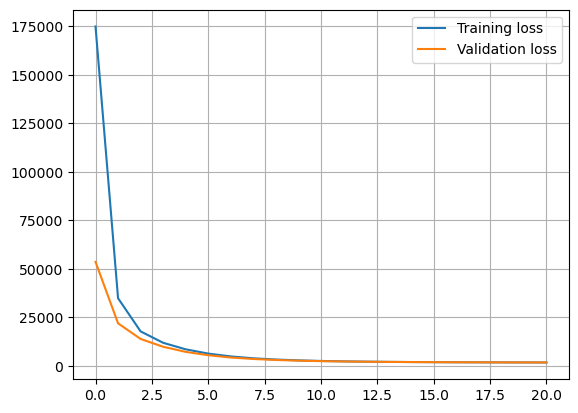

CPU times: user 9min 38s, sys: 34.6 s, total: 10min 13s
Wall time: 10min 18s


In [20]:
%%time
# MSE
_error_fn = lambda prediction, ys: jnp.nanmean((prediction-ys)**2)
error_fn_name = 'mse'

train_loss_out, val_loss_out = train_and_store(subset_name = subset_name,
                                               obs_name = obs_name,
                                               _error_fn = _error_fn,
                                               error_fn_name = error_fn_name,
                                               n_epochs = 20)

# Plot
fig, ax = plt.subplots()
ax.plot(train_loss_out, label='Training loss')
ax.plot(val_loss_out, label='Validation loss')
ax.legend()
ax.grid()
plt.show()

Epoch 0 train loss: 54.14, val loss: 41.40
Epoch 5 train loss: 34.65, val loss: 33.98
Epoch 10 train loss: 34.23, val loss: 33.86
Epoch 15 train loss: 34.12, val loss: 33.57
Epoch 20 train loss: 34.08, val loss: 33.54


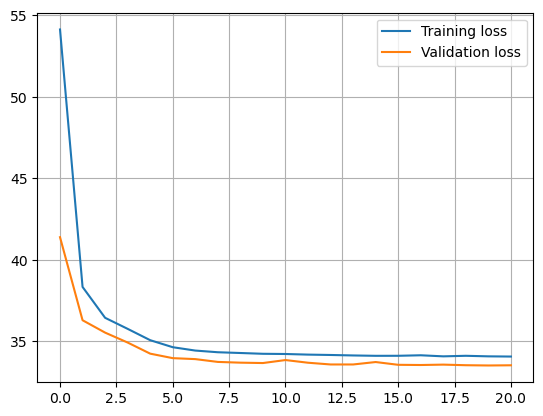

CPU times: user 9min 53s, sys: 34.7 s, total: 10min 28s
Wall time: 10min 34s


In [21]:
%%time
# RMSE
_error_fn = lambda prediction, ys: jnp.sqrt(jnp.nanmean((prediction-ys)**2))
error_fn_name = 'rmse'

train_loss_out, val_loss_out = train_and_store(subset_name = subset_name,
                                               obs_name = obs_name,
                                               _error_fn = _error_fn,
                                               error_fn_name = error_fn_name,
                                               n_epochs = 20)

# Plot
fig, ax = plt.subplots()
ax.plot(train_loss_out, label='Training loss')
ax.plot(val_loss_out, label='Validation loss')
ax.legend()
ax.grid()
plt.show()

Epoch 0 train loss: 168.19, val loss: 71.81
Epoch 5 train loss: 36.29, val loss: 36.10
Epoch 10 train loss: 31.86, val loss: 32.32
Epoch 15 train loss: 30.48, val loss: 31.02
Epoch 20 train loss: 29.96, val loss: 30.57
Epoch 25 train loss: 29.80, val loss: 30.40
Epoch 30 train loss: 29.71, val loss: 30.25


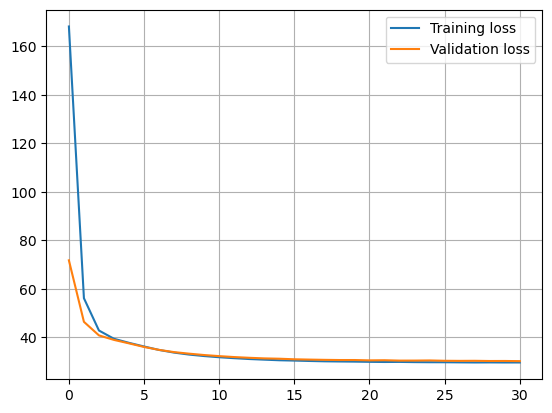

CPU times: user 16min 47s, sys: 50.3 s, total: 17min 37s
Wall time: 17min 43s


In [24]:
%%time
# Quantile RMSE
qmax = 0.25
size = round(N * qmax)

def _error_fn(prediction, ys):
    thresh = jnp.quantile(ys, qmax)
    inds = jnp.where(ys <= thresh, size=size)
    prediction_q = prediction[inds]
    ys_q = ys[inds]
    return jnp.sqrt(jnp.nanmean((prediction_q - ys_q)**2))

error_fn_name = 'q0-25rmse'

train_loss_out, val_loss_out = train_and_store(subset_name = subset_name,
                                               obs_name = obs_name,
                                               _error_fn = _error_fn,
                                               error_fn_name = error_fn_name,
                                               n_epochs = 30)

# Plot
fig, ax = plt.subplots()
ax.plot(train_loss_out, label='Training loss')
ax.plot(val_loss_out, label='Validation loss')
ax.legend()
ax.grid()
plt.show()

### SMAP

In [32]:
# Info
subset_name = 'centralUS'
obs_name = 'SMAP'

# needed for quantile RMSE
N = np.load(f'{project_data_path}/WBM/precalibration/{subset_name}/{obs_name}/{obs_name}_validation.npy').shape[-1]

In [ ]:
%%time
# RMSE
_error_fn = lambda prediction, ys: jnp.sqrt(jnp.nanmean((prediction-ys)**2))
error_fn_name = 'rmse'

train_loss_out, val_loss_out = train_and_store(subset_name = subset_name,
                                               obs_name = obs_name,
                                               _error_fn = _error_fn,
                                               error_fn_name = error_fn_name,
                                               n_epochs = 30)

# Plot
fig, ax = plt.subplots()
ax.plot(train_loss_out, label='Training loss')
ax.plot(val_loss_out, label='Validation loss')
ax.legend()
ax.grid()
plt.show()

Epoch 0 train loss: 53.30, val loss: 43.05
Epoch 5 train loss: 34.37, val loss: 34.16
Epoch 10 train loss: 30.61, val loss: 30.78
Epoch 15 train loss: 30.10, val loss: 30.26


Epoch 0 train loss: 49.07, val loss: 41.01
Epoch 5 train loss: 33.23, val loss: 32.49
Epoch 10 train loss: 30.83, val loss: 30.49
Epoch 15 train loss: 30.45, val loss: 30.13
Epoch 20 train loss: 30.37, val loss: 30.17
Epoch 25 train loss: 30.29, val loss: 30.01
Epoch 30 train loss: 30.29, val loss: 29.95


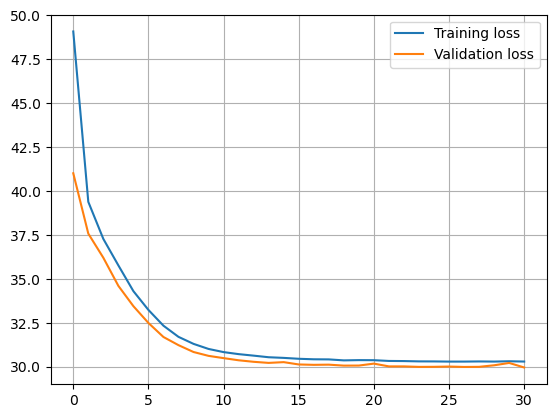

CPU times: user 13min 54s, sys: 50.3 s, total: 14min 44s
Wall time: 14min 50s


In [31]:
%%time
# RMSE
_error_fn = lambda prediction, ys: jnp.sqrt(jnp.nanmean((prediction-ys)**2))
error_fn_name = 'rmse'

train_loss_out, val_loss_out = train_and_store(subset_name = subset_name,
                                               obs_name = obs_name,
                                               _error_fn = _error_fn,
                                               error_fn_name = error_fn_name,
                                               n_epochs = 30)

# Plot
fig, ax = plt.subplots()
ax.plot(train_loss_out, label='Training loss')
ax.plot(val_loss_out, label='Validation loss')
ax.legend()
ax.grid()
plt.show()

In [ ]:
%%time
# MSE
_error_fn = lambda prediction, ys: jnp.nanmean((prediction-ys)**2)
error_fn_name = 'mse'

train_loss_out, val_loss_out = train_and_store(subset_name = subset_name,
                                               obs_name = obs_name,
                                               _error_fn = _error_fn,
                                               error_fn_name = error_fn_name,
                                               n_epochs = 30)

# Plot
fig, ax = plt.subplots()
ax.plot(train_loss_out, label='Training loss')
ax.plot(val_loss_out, label='Validation loss')
ax.legend()
ax.grid()
plt.show()

Epoch 0 train loss: 3441.35, val loss: 2649.71
Epoch 5 train loss: 1802.54, val loss: 1858.18
Epoch 10 train loss: 1740.96, val loss: 1798.05
Epoch 15 train loss: 1721.99, val loss: 1798.82
Epoch 20 train loss: 1715.49, val loss: 1781.27
Epoch 25 train loss: 1708.10, val loss: 1770.37
Epoch 30 train loss: 1703.05, val loss: 1771.19


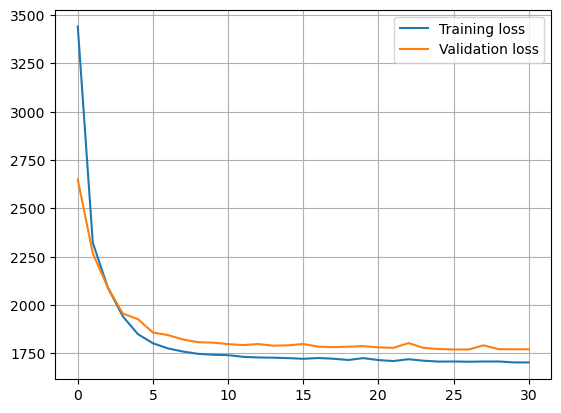

CPU times: user 14min 2s, sys: 51.9 s, total: 14min 54s
Wall time: 14min 59s


In [30]:
%%time
# MSE
_error_fn = lambda prediction, ys: jnp.nanmean((prediction-ys)**2)
error_fn_name = 'mse'

train_loss_out, val_loss_out = train_and_store(subset_name = subset_name,
                                               obs_name = obs_name,
                                               _error_fn = _error_fn,
                                               error_fn_name = error_fn_name,
                                               n_epochs = 30)

# Plot
fig, ax = plt.subplots()
ax.plot(train_loss_out, label='Training loss')
ax.plot(val_loss_out, label='Validation loss')
ax.legend()
ax.grid()
plt.show()

In [ ]:
%%time
# Quantile RMSE
qmax = 0.25
size = round(N * qmax)

def _error_fn(prediction, ys):
    thresh = jnp.quantile(ys, qmax)
    inds = jnp.where(ys <= thresh, size=size)
    prediction_q = prediction[inds]
    ys_q = ys[inds]
    return jnp.sqrt(jnp.nanmean((prediction_q - ys_q)**2))

error_fn_name = 'q0-25rmse'

train_loss_out, val_loss_out = train_and_store(subset_name = subset_name,
                                               obs_name = obs_name,
                                               _error_fn = _error_fn,
                                               error_fn_name = error_fn_name,
                                               n_epochs = 30)

# Plot
fig, ax = plt.subplots()
ax.plot(train_loss_out, label='Training loss')
ax.plot(val_loss_out, label='Validation loss')
ax.legend()
ax.grid()
plt.show()

Epoch 0 train loss: 37.49, val loss: 29.23
Epoch 5 train loss: 26.13, val loss: 24.86
Epoch 10 train loss: 24.07, val loss: 23.29
Epoch 15 train loss: 23.53, val loss: 22.69
Epoch 20 train loss: 23.43, val loss: 22.80
Epoch 25 train loss: 23.33, val loss: 22.53
Epoch 30 train loss: 23.30, val loss: 22.60


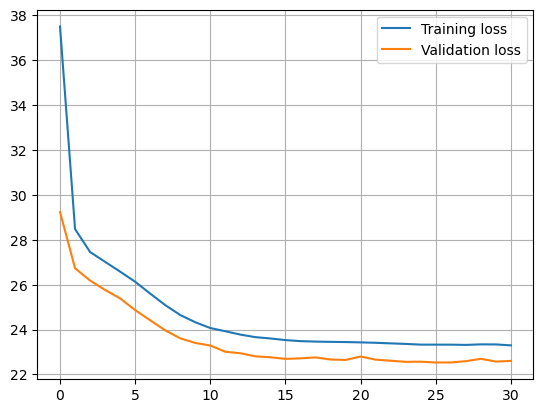

CPU times: user 16min 58s, sys: 52.5 s, total: 17min 50s
Wall time: 17min 57s


In [29]:
%%time
# Quantile RMSE
qmax = 0.25
size = round(N * qmax)

def _error_fn(prediction, ys):
    thresh = jnp.quantile(ys, qmax)
    inds = jnp.where(ys <= thresh, size=size)
    prediction_q = prediction[inds]
    ys_q = ys[inds]
    return jnp.sqrt(jnp.nanmean((prediction_q - ys_q)**2))

error_fn_name = 'q0-25rmse'

train_loss_out, val_loss_out = train_and_store(subset_name = subset_name,
                                               obs_name = obs_name,
                                               _error_fn = _error_fn,
                                               error_fn_name = error_fn_name,
                                               n_epochs = 30)

# Plot
fig, ax = plt.subplots()
ax.plot(train_loss_out, label='Training loss')
ax.plot(val_loss_out, label='Validation loss')
ax.legend()
ax.grid()
plt.show()

### MOSAIC

In [8]:
# Info
subset_name = 'centralUS'
obs_name = 'MOSAIC'

# needed for quantile RMSE
N = np.load(f'{project_data_path}/WBM/precalibration/{subset_name}/{obs_name}/{obs_name}_validation.npy').shape[-1]

In [30]:
%%time
# MSE
_error_fn = lambda prediction, ys: jnp.nanmean((prediction-ys)**2)
error_fn_name = 'mse'

train_loss_out, val_loss_out = train_and_store(subset_name = subset_name,
                                               obs_name = obs_name,
                                               _error_fn = _error_fn,
                                               error_fn_name = error_fn_name,
                                               n_epochs = 20)

# Plot
fig, ax = plt.subplots()
ax.plot(train_loss_out, label='Training loss')
ax.plot(val_loss_out, label='Validation loss')
ax.legend()
plt.show()

Epoch 0 train loss: 2075.70, val loss: 1701.59
Epoch 5 train loss: 1477.01, val loss: 1471.30
Epoch 10 train loss: 1426.51, val loss: 1428.72
Epoch 15 train loss: 1414.37, val loss: 1415.69
Epoch 20 train loss: 1409.23, val loss: 1411.89
CPU times: user 8min 9s, sys: 35.7 s, total: 8min 45s
Wall time: 8min 47s


Array([ 5.4506040e-03,  5.9477901e-01, -3.9724021e+00, -4.1425996e+00,
       -3.9160085e+00, -1.3871255e+00,  7.5021648e-01, -6.9312084e-01,
       -5.3155770e+00,  4.6577921e+00,  5.2857647e+00, -1.7095819e+00,
       -9.8813409e-01, -1.2835183e+00, -1.4474591e+00,  8.1683624e-01,
       -1.3074603e+00,  3.9807102e-01, -1.4370537e+00,  5.1897082e+00,
        5.9274678e+00, -1.0217478e+00, -4.6940878e-01, -1.7730453e+00,
       -2.4766564e+00, -3.1036669e-01, -8.7197953e-01, -2.2772985e+00,
       -2.2364104e+00,  3.9688535e+00,  3.9150999e+00, -1.4352461e+00,
       -1.5234064e+00, -1.6070838e+00,  1.7989107e+00, -2.7093314e-02,
       -1.5812473e+00, -3.3304441e-01, -1.4224908e+00,  4.4251370e+00,
        4.7886982e+00,  1.1859472e+00, -1.1536671e+00, -1.7863824e+00,
       -6.7517948e+00, -6.1977428e-01, -1.5214258e+00, -5.0799789e+00,
       -3.7942235e+00,  4.1200757e+00,  5.5286016e+00, -2.3091424e+00,
       -1.5978048e+00, -2.6410839e-01,  6.9427198e-01,  7.1063709e-01,
      

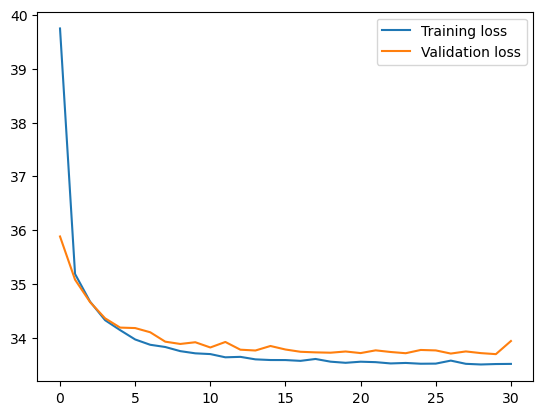

CPU times: user 98 ms, sys: 5.99 ms, total: 104 ms
Wall time: 165 ms


Array([-0.10538837,  0.622152  , -5.0056605 , -5.033066  , -4.938079  ,
        0.5898797 ,  0.98396915, -0.83464503, -5.107264  ,  4.632151  ,
        5.7191243 , -1.9576882 , -1.2498043 , -0.6121338 , -1.2209563 ,
        0.5818649 , -0.5388626 ,  0.6926406 , -1.2438873 ,  5.2757516 ,
        5.9707055 , -0.84925634, -0.40475535, -1.8352299 , -3.4743876 ,
       -0.38254312, -0.9027956 , -4.0107265 , -3.9570613 ,  4.088111  ,
        3.8467429 , -1.3236015 , -1.424244  , -1.7845207 ,  2.3005855 ,
        0.10062643, -1.587839  ,  0.9005905 , -1.7243875 ,  4.430444  ,
        4.88286   ,  1.0745958 , -1.2228045 , -1.763685  , -7.708662  ,
       -0.63327163, -1.4527401 , -5.918706  , -4.5262628 ,  4.648857  ,
        5.2066126 , -1.5249996 , -1.4166528 , -0.7804918 ,  0.5876215 ,
        0.9894287 ,  0.12806106,  0.43606326, -1.6669327 ,  4.3329563 ,
        4.6091423 , -1.3981713 , -1.8586179 , -1.3154036 , -3.710097  ,
       -0.13574427, -1.6818904 , -5.388091  , -3.447086  ], dtyp

In [36]:
%%time
# RMSE
_error_fn = lambda prediction, ys: jnp.sqrt(jnp.nanmean((prediction-ys)**2))
error_fn_name = 'rmse'

train_loss_out, val_loss_out = train_and_store(subset_name = subset_name,
                                               obs_name = obs_name,
                                               _error_fn = _error_fn,
                                               error_fn_name = error_fn_name,
                                               n_epochs = 30)

# Plot
fig, ax = plt.subplots()
ax.plot(train_loss_out, label='Training loss')
ax.plot(val_loss_out, label='Validation loss')
ax.legend()
ax.grid()
plt.show()

In [ ]:
%%time
# Quantile RMSE
qmax = 0.25
size = round(N * qmax)

def _error_fn(prediction, ys):
    thresh = jnp.quantile(ys, q)
    inds = jnp.where(ys <= thresh, size=size)
    prediction_q = prediction[inds]
    ys_q = ys[inds]
    return jnp.sqrt(jnp.nanmean((prediction_q - ys_q)**2))

error_fn_name = 'q0-25rmse'

train_loss_out, val_loss_out = train_and_store(subset_name = subset_name,
                                               obs_name = obs_name,
                                               _error_fn = _error_fn,
                                               error_fn_name = error_fn_name,
                                               n_epochs = 30)

# Plot
fig, ax = plt.subplots()
ax.plot(train_loss_out, label='Training loss')
ax.plot(val_loss_out, label='Validation loss')
ax.legend()
ax.grid()
plt.show()

Epoch 0 train loss: 16.15, val loss: 13.50
Epoch 5 train loss: 13.03, val loss: 12.74


### NOAH

In [13]:
# Info
subset_name = 'centralUS'
obs_name = 'NOAH'

# needed for quantile RMSE
N = np.load(f'{project_data_path}/WBM/precalibration/{subset_name}/{obs_name}/{obs_name}_validation.npy').shape[-1]

In [30]:
%%time
# MSE
_error_fn = lambda prediction, ys: jnp.nanmean((prediction-ys)**2)
error_fn_name = 'mse'

train_loss_out, val_loss_out = train_and_store(subset_name = subset_name,
                                               obs_name = obs_name,
                                               _error_fn = _error_fn,
                                               error_fn_name = error_fn_name,
                                               n_epochs = 20)

# Plot
fig, ax = plt.subplots()
ax.plot(train_loss_out, label='Training loss')
ax.plot(val_loss_out, label='Validation loss')
ax.legend()
plt.show()

Epoch 0 train loss: 2075.70, val loss: 1701.59
Epoch 5 train loss: 1477.01, val loss: 1471.30
Epoch 10 train loss: 1426.51, val loss: 1428.72
Epoch 15 train loss: 1414.37, val loss: 1415.69
Epoch 20 train loss: 1409.23, val loss: 1411.89
CPU times: user 8min 9s, sys: 35.7 s, total: 8min 45s
Wall time: 8min 47s


Array([ 5.4506040e-03,  5.9477901e-01, -3.9724021e+00, -4.1425996e+00,
       -3.9160085e+00, -1.3871255e+00,  7.5021648e-01, -6.9312084e-01,
       -5.3155770e+00,  4.6577921e+00,  5.2857647e+00, -1.7095819e+00,
       -9.8813409e-01, -1.2835183e+00, -1.4474591e+00,  8.1683624e-01,
       -1.3074603e+00,  3.9807102e-01, -1.4370537e+00,  5.1897082e+00,
        5.9274678e+00, -1.0217478e+00, -4.6940878e-01, -1.7730453e+00,
       -2.4766564e+00, -3.1036669e-01, -8.7197953e-01, -2.2772985e+00,
       -2.2364104e+00,  3.9688535e+00,  3.9150999e+00, -1.4352461e+00,
       -1.5234064e+00, -1.6070838e+00,  1.7989107e+00, -2.7093314e-02,
       -1.5812473e+00, -3.3304441e-01, -1.4224908e+00,  4.4251370e+00,
        4.7886982e+00,  1.1859472e+00, -1.1536671e+00, -1.7863824e+00,
       -6.7517948e+00, -6.1977428e-01, -1.5214258e+00, -5.0799789e+00,
       -3.7942235e+00,  4.1200757e+00,  5.5286016e+00, -2.3091424e+00,
       -1.5978048e+00, -2.6410839e-01,  6.9427198e-01,  7.1063709e-01,
      

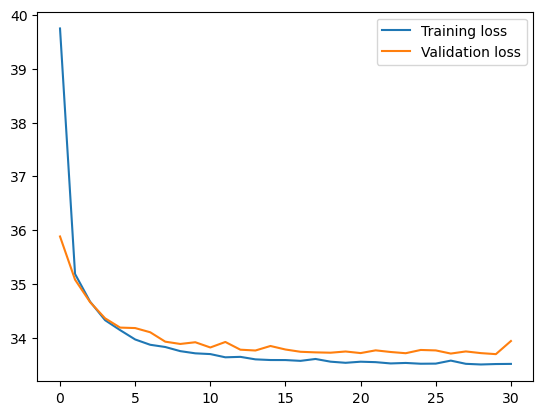

CPU times: user 98 ms, sys: 5.99 ms, total: 104 ms
Wall time: 165 ms


Array([-0.10538837,  0.622152  , -5.0056605 , -5.033066  , -4.938079  ,
        0.5898797 ,  0.98396915, -0.83464503, -5.107264  ,  4.632151  ,
        5.7191243 , -1.9576882 , -1.2498043 , -0.6121338 , -1.2209563 ,
        0.5818649 , -0.5388626 ,  0.6926406 , -1.2438873 ,  5.2757516 ,
        5.9707055 , -0.84925634, -0.40475535, -1.8352299 , -3.4743876 ,
       -0.38254312, -0.9027956 , -4.0107265 , -3.9570613 ,  4.088111  ,
        3.8467429 , -1.3236015 , -1.424244  , -1.7845207 ,  2.3005855 ,
        0.10062643, -1.587839  ,  0.9005905 , -1.7243875 ,  4.430444  ,
        4.88286   ,  1.0745958 , -1.2228045 , -1.763685  , -7.708662  ,
       -0.63327163, -1.4527401 , -5.918706  , -4.5262628 ,  4.648857  ,
        5.2066126 , -1.5249996 , -1.4166528 , -0.7804918 ,  0.5876215 ,
        0.9894287 ,  0.12806106,  0.43606326, -1.6669327 ,  4.3329563 ,
        4.6091423 , -1.3981713 , -1.8586179 , -1.3154036 , -3.710097  ,
       -0.13574427, -1.6818904 , -5.388091  , -3.447086  ], dtyp

In [36]:
%%time
# RMSE
_error_fn = lambda prediction, ys: jnp.sqrt(jnp.nanmean((prediction-ys)**2))
error_fn_name = 'rmse'

train_loss_out, val_loss_out = train_and_store(subset_name = subset_name,
                                               obs_name = obs_name,
                                               _error_fn = _error_fn,
                                               error_fn_name = error_fn_name,
                                               n_epochs = 30)

# Plot
fig, ax = plt.subplots()
ax.plot(train_loss_out, label='Training loss')
ax.plot(val_loss_out, label='Validation loss')
ax.legend()
ax.grid()
plt.show()

In [ ]:
%%time
# Quantile RMSE
qmax = 0.25
size = round(N * qmax)

def _error_fn(prediction, ys):
    thresh = jnp.quantile(ys, q)
    inds = jnp.where(ys <= thresh, size=size)
    prediction_q = prediction[inds]
    ys_q = ys[inds]
    return jnp.sqrt(jnp.nanmean((prediction_q - ys_q)**2))

error_fn_name = 'q0-25rmse'

train_loss_out, val_loss_out = train_and_store(subset_name = subset_name,
                                               obs_name = obs_name,
                                               _error_fn = _error_fn,
                                               error_fn_name = error_fn_name,
                                               n_epochs = 30)

# Plot
fig, ax = plt.subplots()
ax.plot(train_loss_out, label='Training loss')
ax.plot(val_loss_out, label='Validation loss')
ax.legend()
ax.grid()
plt.show()

Epoch 0 train loss: 16.15, val loss: 13.50
Epoch 5 train loss: 13.03, val loss: 12.74


# Plots

In [25]:
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.lines import Line2D
import cartopy.feature as cfeature

from glob import glob

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 10
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.50

In [26]:
# Read sim
def plot_precal_best_ts(obs, lat, lon, title, ax):
    # Read obs
    ds_obs = xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS_AGU/{obs.upper()}/{obs.upper()}_validation.nc').sel(lat=lat, lon=lon, method='nearest')
    
    # Get top N_cutoff params
    df_res = pd.read_csv(f'{project_data_path}/WBM/precalibration/centralUS_AGU/{obs.upper()}/soilMoist_rmse_skip0.csv')
    iparam_best = df_res.sort_values(by='rmse_gpa')['iparam'].to_numpy()[0]
    
    # Read simulation output
    sim_tmp = np.load(f'{project_data_path}/WBM/precalibration/centralUS_AGU/{obs.upper()}/out/{str(iparam_best)}.npy')
    # sim_tmp = np.load(f'{project_data_path}/WBM/precalibration/centralUS_old/out/{str(iparam)}.npy')

    # Construct xr 
    ds_sim = xr.Dataset(
            data_vars=dict(soilMoist=(["time", "lat", "lon"], np.transpose(sim_tmp, (2,1,0)))),
            coords=dict(
                lon=np.arange(-103.938, -80.5629999, 0.125), # CENTRAL US ONLY!
                lat=np.arange(36.063, 49.313001, 0.125), # CENTRAL US ONLY!
                time=pd.date_range(start='01/01/2016', end='12/31/2022')))
    ds_sim = ds_sim.sel(lat=lat, lon=lon, method='nearest')
    
    # Plot
    ds_obs['soilMoist'].plot(ax=ax, color='C0', zorder=2, label='Obs.')
    ds_sim['soilMoist'].plot(ax=ax, color='C1', zorder=3, label='Best precalibration sim.')

    # Info
    best_rmse = np.sqrt(((ds_sim['soilMoist'] - ds_obs['soilMoist'])**2).mean())
    best_corr = np.corrcoef(ds_sim['soilMoist'], ds_obs['soilMoist'])[0,1]

    text = f"RMSE: {best_rmse:.2f}mm, Corr.: {best_corr:.2f}"
    ax.text(x=0.03, y=0.96,
            s = text,
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=9)

    ax.grid()
    ax.legend(loc='lower right')
    ax.set_title(title)
    ax.set_ylabel("Soil Moisture")
    ax.set_xlabel('')
    return ds_sim

In [27]:
# Read sim
def plot_precal_map(obs, title, ax):
    # Read obs
    ds_obs = xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS_AGU/{obs.upper()}/{obs.upper()}_validation.nc')
    
    # Get top N_cutoff params
    df_res = pd.read_csv(f'{project_data_path}/WBM/precalibration/centralUS_AGU/{obs.upper()}/soilMoist_rmse_skip0.csv')
    iparam_best = df_res.sort_values(by='rmse_gpa')['iparam'].to_numpy()[0]
    
    # Read simulation output
    sim_tmp = np.load(f'{project_data_path}/WBM/precalibration/centralUS_AGU/{obs.upper()}/out/{str(iparam_best)}.npy')
    # sim_tmp = np.load(f'{project_data_path}/WBM/precalibration/centralUS_old/out/{str(iparam)}.npy')

    # Construct xr 
    ds_sim = xr.Dataset(
            data_vars=dict(soilMoist=(["time", "lat", "lon"], np.transpose(sim_tmp, (2,1,0)))),
            coords=dict(
                lon=np.arange(-103.938, -80.5629999, 0.125), # CENTRAL US ONLY!
                lat=np.arange(36.063, 49.313001, 0.125), # CENTRAL US ONLY!
                time=pd.date_range(start='01/01/2016', end='12/31/2022')))
    
    # Plot
    ds_rmse = np.sqrt(((ds_sim['soilMoist'] - ds_obs['soilMoist'])**2).mean(dim='time'))
    p = ds_rmse.plot(ax=ax, vmin=0, vmax=100, add_colorbar=False, levels=11, cmap = "Oranges", transform=ccrs.PlateCarree())
    
    ax.coastlines()
    ax.set_title(title)
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)

    return p

In [28]:
# Read sim
def read_jax(obs, param_read_str):
    # Get simulation output
    ys, x_forcing_nt, x_forcing_nyrs, x_maps = read_inputs('centralUS', obs, False)
    
    spatial_vmap = jax.jit(jax.vmap(make_prediction, in_axes=(None, None, 0, 0, 0), out_axes=0))

    files = glob(f'{project_data_path}/WBM/precalibration/centralUS/{obs}/training_res/*{param_read_str}*')[0]
    
    # Plot all 
    res = glob(f"{project_data_path}//WBM/precalibration/")
    df_res = pd.read_csv('/WBM/precalibration/centralUS/SMAP/training_res/rmse_10epochs_128batchsize_adam-opt_20240125-1621.txt',
                     sep = ' ')


    theta = pd.read_csv(file, sep=';', names = ['info', 'theta']).iloc[-1]['theta'].replace(' theta: ', '').split(',')
    theta = jnp.array([float(x) for x in theta])

    out = spatial_vmap(
        theta,
        constants,
        x_forcing_nt,
        x_forcing_nyrs,
        x_maps
        )

    # Construct xr 
    lons = np.arange(-103.938, -80.5629999, 0.125)
    lats = np.arange(36.063, 49.313001, 0.125)
    nt = out.shape[1]

    ds_sim = xr.Dataset(
        data_vars=dict(soilMoist=(["time", "lat", "lon"], np.transpose(out.reshape(len(lons), len(lats), nt), (2,1,0)))),
        coords=dict(
            lon=lons,
            lat=lats,
            time=pd.date_range(start='01/01/2016', end='12/31/2022', periods=nt)))

    ds_obs = xr.Dataset(
        data_vars=dict(soilMoist=(["time", "lat", "lon"], np.transpose(ys.reshape(len(lons), len(lats), nt), (2,1,0)))),
        coords=dict(
            lon=lons,
            lat=lats,
            time=pd.date_range(start='01/01/2016', end='12/31/2022', periods=nt)))

    return ds_sim, ds_obs

In [31]:
def plot_jax_ts_all(obs, lat, lon, thresh, title, ax):
    def find_nearest(array, value):
        array = np.asarray(array)
        return (np.abs(array - value)).argmin()
    
    # Get simulation output
    ys, x_forcing_nt, x_forcing_nyrs, x_maps = read_inputs('centralUS', obs, False)

    # Get correct idx
    lons = np.arange(-103.938, -80.5629999, 0.125)
    lats = np.arange(36.063, 49.313001, 0.125)
    idx_to_find = (find_nearest(lons, lon), find_nearest(lats, lat))
    shape_to_search = (x_maps.shape[0],)
    original_shape = (len(lons), len(lats))
    idx = np.unravel_index(np.ravel_multi_index(idx_to_find, original_shape), shape_to_search)[0]

    # Plot obs
    dates = pd.date_range(start='01/01/2016', end='12/31/2022', periods=len(ys[idx,:]))
    ax.plot(dates, ys[idx,:], color='darkred', zorder=3, label='Obs.')
    
    # Loop through files
    files = glob(f'{project_data_path}/WBM/precalibration/centralUS/{obs}/training_res/*.txt')

    # Record count and best RMSE
    count = 0
    best_rmse = 100
    best_corr = 0.
    for file in files:
        # Read
        df = pd.read_csv(file, sep = ' ')
        
        # Take all val_loss within 1%
        best_val_loss = df['val_loss'].min()
        df_top = df[df['val_loss']/best_val_loss <= thresh]
        
        for index, row in df_top.iterrows():
            # Get params
            theta = jnp.array([row[param] for param in param_names])
            
            # Simulate
            sim = make_prediction(theta, constants, x_forcing_nt[idx,:,:], x_forcing_nyrs[idx,:], x_maps[idx,:])

            # Plot
            ax.plot(dates, sim, color='silver', alpha=0.8, zorder=2)

            # Update
            count += 1
            
            rmse = np.sqrt(np.mean((sim - ys[idx,:])**2))
            if rmse < best_rmse:
                best_rmse = rmse

            corr = np.corrcoef(sim, ys[idx,:])[0,1]
            if corr > best_corr:
                best_corr = corr

    # Add info
    text = f"Best RMSE: {best_rmse:.2f}mm; Best Corr.: {best_corr:.2f}"
    ax.text(x=0.03, y=0.96,
            s = text,
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=9)
    
    ax.text(x=0.77, y=0.96,
            s=f"Ensemble size: {str(count)}",
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=9)
    
    ax.grid()
    ax.legend(loc='lower right')
    ax.set_title(title)
    ax.set_ylabel("Soil Moisture")
    ax.set_xlabel('')

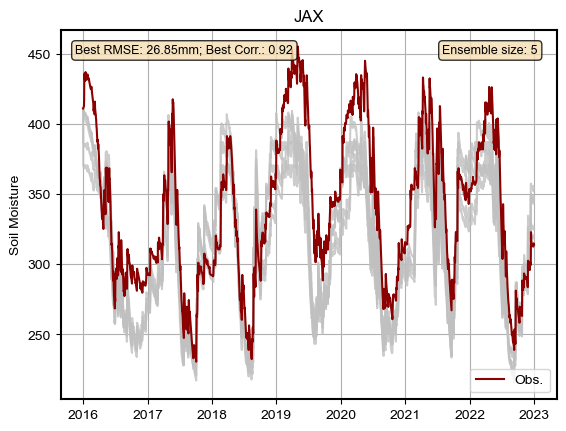

In [37]:
fig, ax = plt.subplots()
plot_jax_ts_all(obs='SMAP',
                lat=40,
                lon=-91,
                thresh=1.001,
                title='JAX',
                ax=ax)
plt.show()

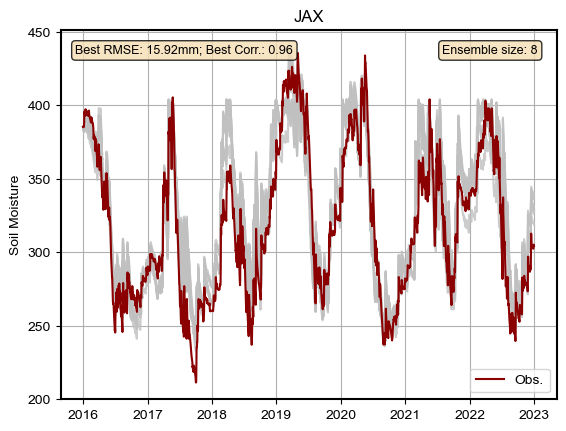

In [362]:
fig, ax = plt.subplots()
plot_jax_ts_all(obs='SMAP',
                lat=40,
                lon=-90,
                thresh=1.01,
                title='JAX',
                ax=ax)
plt.show()

In [158]:
def plot_jax_map(ds_sim, ds_obs, title, ax):
    # Plot
    ds_rmse = np.sqrt(((ds_sim['soilMoist'] - ds_obs['soilMoist'])**2).mean(dim='time'))
    p = ds_rmse.plot(ax=ax, vmin=0, vmax=100, add_colorbar=False, levels=11, cmap = "Oranges", transform=ccrs.PlateCarree())
    
    ax.coastlines()
    ax.set_title(title)
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)

    return p

In [150]:
# Read JAX
obs = "SMAP"

ds_sim_rmse, ds_obs = read_jax(obs, '_rmse_')
ds_sim_mse, ds_obs = read_jax(obs, '_mse_')

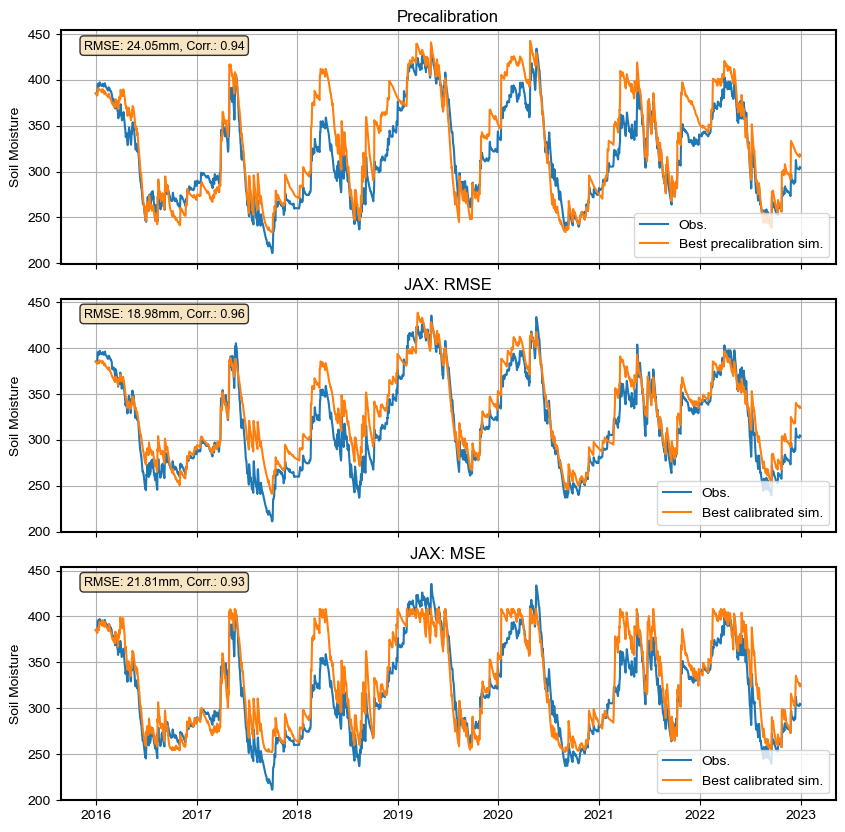

In [160]:
fig, axs = plt.subplots(3,1, figsize=(10,10), sharex=True, sharey=True, gridspec_kw={"hspace":0.15})

lat, lon = 40, -90

plot_precal_best_ts(obs, lat, lon, 'Precalibration', axs[0])

plot_jax_ts(ds_sim_rmse, ds_obs, lat, lon, 'JAX: RMSE', axs[1])

plot_jax_ts(ds_sim_mse, ds_obs, lat, lon, 'JAX: MSE', axs[2])

plt.show()

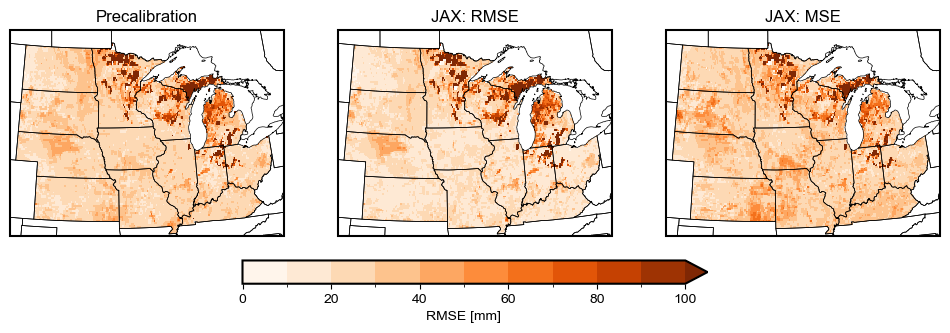

In [161]:
fig, axs = plt.subplots(1, 3, figsize=(12, 8),
                       subplot_kw=dict(projection=ccrs.LambertConformal()))

p = plot_precal_map(obs, 'Precalibration', axs[0])
p = plot_jax_map(ds_sim_rmse, ds_obs, 'JAX: RMSE', axs[1])
p = plot_jax_map(ds_sim_mse, ds_obs, 'JAX: MSE', axs[2])

fig.colorbar(p,
             orientation="horizontal",
             label=f"RMSE [mm]",
             ax=axs,
             shrink=0.5,
             pad=0.04)

plt.show()

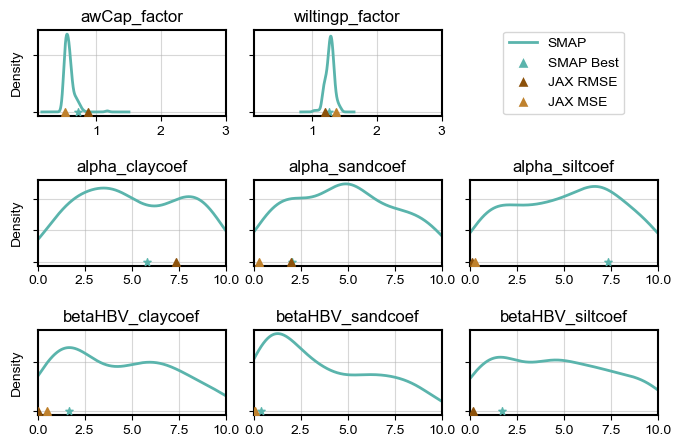

In [179]:
# Do the parameters match?
n_cutoff = 150
metric = 'rmse_gpa'
tmin = 0

#######################
# PRECAL
#######################
# Read params
df_params = pd.read_csv(f'{project_data_path}/WBM/precalibration/centralUS_AGU/params_extra.csv')

params = ['awCap_factor',
          'wiltingp_factor',
          'alpha_claycoef', 'alpha_sandcoef', 'alpha_siltcoef',
          'betaHBV_claycoef', 'betaHBV_sandcoef', 'betaHBV_siltcoef']
priors = ['U(0.1, 5)',
          'U(0.1, 5)',
          'U(0, 10)', 'U(0, 10)', 'U(0, 10)',
          'U(0, 10)', 'U(0, 10)', 'U(0, 10)']
xlims = [[0.1, 3],
          [0.1, 3],
          [0, 10], [0, 10], [0, 10],
          [0, 10], [0, 10], [0, 10]]
# obs_all = ['noah', 'mosaic']
# obs_colors = ['C0', 'C0', 'C0', 'C0']

obs_all = ['smap', 'vic', 'noah', 'mosaic']
obs_colors = ['#5ab4ac', '#8c510a', '#bf812d', '#d8b365']

obs_all = [obs]
obs_colors = ['#5ab4ac']

fig, axs = plt.subplots(3,3, figsize=(8,5), sharey='row', gridspec_kw={'hspace':0.75, 'wspace':0.15})
axs=axs.flatten()

for ido, obs in enumerate(obs_all):
    # Get top params
    df_res = pd.read_csv(f'{project_data_path}/WBM/precalibration/centralUS_AGU/{obs.upper()}/soilMoist_rmse_skip{str(tmin)}.csv')
        
    iparam_top_n = df_res.sort_values(by=metric)['iparam'].to_numpy()[:n_cutoff]
    iparam_best = iparam_top_n[0]

    # Loop through params
    for idx, param in enumerate(params):
        if idx >= 2:
            idxx = idx + 1
        else:
            idxx = idx
        # Plot
        df_params.iloc[iparam_top_n][param].plot.kde(ax=axs[idxx], color=obs_colors[ido], label=obs_all[ido], lw=2)
        # Best
        axs[idxx].scatter(x = [df_params.iloc[iparam_best][param]],
                         y = [0],
                         marker = '*', color=obs_colors[ido], zorder=100, s=30)


for idx, param in enumerate(params):
    if idx >= 2:
        idxx = idx + 1
    else:
        idxx = idx
    axs[idxx].set_title(f'{param}')
    axs[idxx].set_xlim(xlims[idx])
    axs[idxx].set_yticklabels([])
    axs[idxx].grid(alpha=0.5)

###########################
# JAX
#########################
jax_colors = ['#8c510a', '#bf812d']

for ido, param_read_str in enumerate(['_rmse_', '_mse_']):
    file = glob(f'{project_data_path}/WBM/precalibration/centralUS/{obs}/training_res/*{param_read_str}*')[0]
    theta = pd.read_csv(file, sep=';', names = ['info', 'theta']).iloc[-1]['theta'].replace(' theta: ', '').split(',')
    theta = np.exp([float(x) for x in theta])
    # Loop through params
    for idx, param in enumerate(params):
        if idx >= 2:
            idxx = idx + 1
        else:
            idxx = idx
        # Best
        axs[idxx].scatter(x = [theta[idx]],
                         y = [0],
                         marker = '^', color=jax_colors[ido], zorder=100, s=30)

# Legend in odd plot
axs[2].axis("off")
axs[2].set_xlim(axs[2].get_xlim())
axs[2].set_ylim(axs[2].get_ylim())
legend_elements = [Line2D([10], [10], color=obs_colors[0], lw=2, label=obs_all[0].upper()),
                    # Line2D([10], [10], color=obs_colors[3], lw=2, label=obs_all[3].upper()),
                    Line2D([10], [10], marker='^', markerfacecolor=obs_colors[0], color='w', markersize=9, label='SMAP Best'),
                    Line2D([10], [10], marker='^', markerfacecolor=jax_colors[0], color='w', markersize=9, label='JAX RMSE'),
                    Line2D([10], [10], marker='^', markerfacecolor=jax_colors[1], color='w', markersize=9, label='JAX MSE')]

axs[2].legend(handles=legend_elements, loc='center')

plt.show()

In [9]:
# ixy = 14503

# plt.plot(make_prediction(initial_params, constants, x_forcing_nt[ixy, :, :], x_forcing_nyrs[ixy, :], x_maps[ixy, :]))
# plt.plot(ys[ixy,:])
# loss_fn(initial_params,constants,x_forcing_nt[ixy,:,:], x_forcing_nyrs[ixy,:] ,x_maps[ixy,:], ys[ixy,:])